In [1]:
import numpy as np
from numba import jit
from numba.experimental import jitclass
from abc import ABC, abstractmethod
from typing import List, Union, Dict
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# this can be compiled
@jit(nopython=True)
def hmm_forward(prob, A, P):
    '''
    Forward algorithm for the HMM
    prob: numpy (n,n_states) array with
        the probability of each observation
        for each state
    A: numpy (n_states,n_states) array with the state
        transition matrix
    P: numpy (n_states,) array with the initial
        state probability
    returns:
        alpha: numpy (n,n_states) array meaning
            p(state=i|obs <= i)
        c: numpy (n,) array with the normalization
            constants
    '''
    n_obs = prob.shape[0]
    n_states = prob.shape[1]
    alpha = np.zeros((n_obs,n_states), dtype = np.float64)
    c = np.zeros(n_obs, dtype = np.float64)
    alpha[0] = P*prob[0]
    c[0] = 1 / np.sum(alpha[0])
    alpha[0] *= c[0]
    for i in range(1, n_obs):
        alpha[i] = np.dot(A.T, alpha[i-1]) * prob[i] 
        c[i] = 1 / np.sum(alpha[i])
        alpha[i] *= c[i]
    return alpha, c

# this can be compiled
@jit(nopython=True)
def hmm_backward_sample(A, alpha, z, transition_counter, init_state_counter):
    '''
    Backward sample from the state transition matrix and state sequence
    A: numpy (n_states,n_states) array with the state
        transition matrix
    alpha: numpy (n,n_states) array meaning
        p(state=i|obs <= i)		
    z: numpy (n,) to store the sample of state sequence
    transition_counter: numpy (n_states,n_states) array to store 
        transition counts to be used to sample a state transition 
        matrix
    init_state_counter: numpy (n_states,) array to store the
        number of times state i is the initial one
    returns:
        none (q and transition_counter are changed inside this function)
    '''	
    # backward walk to sample from the state sequence
    n = z.size
    # sample the last hidden state with probability alpha[-1]
    z[n-1] = np.searchsorted(np.cumsum(alpha[-1]), np.random.random(), side = "right")
    # aux variable
    p = np.zeros(A.shape[0], dtype = np.float64)
    # iterate backwards
    for j in range(n-2, -1, -1):
        # from formula
        p = A[:,z[j+1]] * alpha[j] 
        # normalize (from formula)
        p /= np.sum(p) 
        # sample hidden state with probability p
        z[j] = np.searchsorted(np.cumsum(p), np.random.random(), side="right")
        # increment transition counter (we can do this calculation incrementally)
        transition_counter[z[j],z[j+1]] += 1 
    # increment initial state counter
    init_state_counter[z[0]] += 1


In [3]:
class uEmission(ABC):

    def set_gibbs_parameters(self, n_gibbs, f_burn, n_gibbs_sim = None):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        aux = int(self.n_gibbs*(1+self.f_burn))
        self.n_gibbs_sim = aux if n_gibbs_sim is None else n_gibbs_sim

    @abstractmethod
    def view(self, plot_hist:bool = False):
        """Subclasses must implement this method"""
        pass
            
    @abstractmethod
    def gibbs_initialize(self, y:np.ndarray, x:np.ndarray = None, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def gibbs_posterior_sample(self, y:np.ndarray, x:np.ndarray, iteration:int, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def gibbs_burn_and_mean(self):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def gibbs_prob(self, y:np.ndarray, x:np.ndarray, iteration:int, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def prob(self, y:np.ndarray, x:np.ndarray, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def posterior_predictive(self, xq:np.ndarray, **kwargs):
        """Subclasses must implement this method"""
        pass
    
    @abstractmethod
    def predict_pi(self, xq:np.ndarray, **kwargs):
        """Subclasses must implement this method"""
        pass


In [9]:
# univariate HMM

class uHMM(object):
    def __init__(
                self,
                emissions:List[uEmission] = [],
                n_gibbs = 1000,
                A_zeros = [],
                emissions_indexes = [],
                f_burn = 0.1,
                pred_l = None,
                roll_var = False,
                phi = 0.95,
                **kwargs
                ):
        '''
        emissions: list of instances derived from Emission
                one for each state
        n_gibbs: number of gibbs samples
        A_zeros: list of lists with entries of A to be set to zero
        emissions_indexes: list of lists
            example
                    emissions_indexes = [[0,2],[1,3]]
                means 
                    emission[0] is applied to states 0 and 2
                    emission[1] is applied to states 1 and 3
                also, this implies that the number of states is 4!
        f_burn: fraction to burn  
        '''
        self.emissions = emissions   
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.A_zeros = A_zeros
        self.emissions_indexes = emissions_indexes 
        if len(self.emissions_indexes) == 0:
            self.n_states = len(self.emissions)
            self.emissions_indexes = [[e] for e in range(self.n_states)]   
        self.n_states = 0 
        for e in self.emissions_indexes: self.n_states += len(e)
        self.n_emissions = len(self.emissions)
        assert len(self.emissions_indexes) == self.n_emissions, "emissions do not match groups"
        # real number of samples to simulate
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.pred_l = None
        self.P = None
        self.gibbs_P = None
        self.A = None
        self.gibbs_A = None
        self.w_norm = 1
        self.roll_var = roll_var
        self.phi = phi
        # **
        for emission in self.emissions:
            emission.set_gibbs_parameters(self.n_gibbs, self.f_burn, self.n_gibbs_sim)
        # **
        # Dirichelet prior parameters
        self.ALPHA = 1
        self.ZERO_ALPHA = 0.001
        self.ALPHA_P = 0.05 
        # A initial mass (persistency)
        self.INIT_MASS = 0.9

    def view(self, plot_hist = False):
        '''
        plot_hist: if true, plot histograms, otherwise just show the parameters
        '''
        print('** HMM **')
        print('Groups')
        for e in self.emissions_indexes:
            print('States %s have the same emission'%','.join([str(a) for a in e]))
        print('Initial state probability')
        print(self.P)
        if plot_hist:
            for i in range(self.n_states):
                plt.hist(self.gibbs_P[:,i], density=True, alpha=0.5, label='P[%s]'%(i))
            plt.legend()
            plt.grid(True)
            plt.show()
        print('State transition matrix')
        print(np.round(self.A,3))
        print()
        if plot_hist:
            for i in range(self.n_states):
                for j in range(self.n_states):
                    if [i,j] not in self.A_zeros:
                        plt.hist(
                                self.gibbs_A[:,i,j],
                                density=True,
                                alpha=0.5,
                                label='A[%s->%s]'%(i,j)
                                )
            plt.legend()
            plt.grid(True)
            plt.show()
        for s, emission in enumerate(self.emissions):
            print(f'HMM Emission {s}')
            emission.view(plot_hist = plot_hist)

    def transitions_dirichlet_priors(self):
        alphas = []
        for s in range(self.n_states):
            tmp = self.ALPHA*np.ones(self.n_states)
            for e in self.A_zeros:
                if e[0] == s:
                    tmp[e[1]] = self.ZERO_ALPHA
            alphas.append(tmp)
        return alphas
    
    def estimate(self, y:np.ndarray, x:np.ndarray = None, msidx = None, **kwargs):	 
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        if x is not None:             
            assert x.ndim == 2,"x must be a matrix"
            assert y.size == x.shape[0], "x and y must have the same number of observations"
        # **
        # number of observations
        n = y.size
        self.y_var = np.var(y)
        if self.roll_var:
            var_est = np.zeros(n)
            var_est[0] = self.y_var
            for i in range(1, n):
                var_est[i] = (1-self.phi)*y[i]*y[i] + self.phi*var_est[i-1]
            y = np.copy(y)
            y = y/np.sqrt(var_est)

        
        # idx for multisequence
        if msidx is None:
            msidx = np.array([[0,n]], dtype = int)
        # convert to integer to make sure this is well defined
        msidx = np.array(msidx, dtype = int)
        # number of sequences
        n_seqs = msidx.shape[0]
        # **
        # **
        # Dirichlet prior
        A_alphas = self.transitions_dirichlet_priors()
        # **
        # **
        # Containers
        # counter for state transitions
        transition_counter = np.zeros((self.n_states, self.n_states)) 
        # counter for initial state observations
        init_state_counter = np.zeros(self.n_states) 
        # # forward alpha
        # forward_alpha = np.zeros((n,self.n_states), dtype = np.float64)
        # # forward normalization variable
        # forward_c = np.zeros(n, dtype = np.float64)
        # probability of observation given state
        prob = np.zeros((n,self.n_states), dtype = np.float64)         
        # transition matrix samples
        self.gibbs_A = np.zeros((self.n_gibbs_sim, self.n_states, self.n_states)) 
        # initial state probability samples
        self.gibbs_P = np.zeros((self.n_gibbs_sim, self.n_states))
        
        # ** 
        # **
        # Initialize
        # Transition matrix A
        # assume some persistency of state as a initial parameter
        tmp = self.INIT_MASS * np.eye(self.n_states)
        remaining_mass = (1-self.INIT_MASS) / (self.n_states - 1)
        tmp[tmp == 0] = remaining_mass	
        # set zeros
        for e in self.A_zeros:
            tmp[e[0],e[1]] = 0
        # normalize
        tmp /= np.sum(tmp,axis=1)[:,None]
        self.gibbs_A[0] = tmp
        
        # Initial State Distribution
        self.gibbs_P[0] = np.ones(self.n_states)
        self.gibbs_P[0] /= np.sum(self.gibbs_P[0])		
        # initialize emissions
        for emission in self.emissions:
            emission.gibbs_initialize(y = y, x = x)
        # **

        # **
        # create and initialize variable with
        # the states associated with each variable
        # assume equal probability in states
        z = np.random.choice(np.arange(self.n_states, dtype = int), size = n)
        # **

        # Gibbs sampler
        for i in range(1, self.n_gibbs_sim):
            # **
            # set counters to zero
            transition_counter *= 0 
            init_state_counter *= 0 
            # **
            # evaluate the probability of each observation
            for s in range(self.n_emissions):
                prob[:,self.emissions_indexes[s]] = self.emissions[s].gibbs_prob(
                                                                                y = y, 
                                                                                x = x, 
                                                                                iteration = i
                                                                                )[:,None]
            # **
            # sample form hidden state variable
            for l in range(n_seqs):
                # compute alpha variable
                forward_alpha, _ = hmm_forward(
                                        prob[msidx[l][0]:msidx[l][1]],
                                        self.gibbs_A[i-1],
                                        self.gibbs_P[i-1]
                                        )
                # backward walk to sample from the state sequence
                hmm_backward_sample(
                                    self.gibbs_A[i-1],
                                    forward_alpha,
                                    z[msidx[l][0]:msidx[l][1]],
                                    transition_counter,
                                    init_state_counter
                                    )
            # **
            # sample from transition matrix
            for s in range(self.n_states):
                self.gibbs_A[i,s] = np.random.dirichlet(A_alphas[s] + transition_counter[s])
            # make sure that the entries are zero!
            for A_zero in self.A_zeros:
                self.gibbs_A[i, A_zero[0], A_zero[1]] = 0.
            # normalize 
            self.gibbs_A[i] /= np.sum(self.gibbs_A[i],axis=1)[:,None]
            # **
            # sample from initial state distribution
            self.gibbs_P[i] = np.random.dirichlet(self.ALPHA_P + init_state_counter)   
            # perform the gibbs step with the state sequence sample q
            for s in range(self.n_emissions):
                idx_states = np.where(np.in1d(z, self.emissions_indexes[s]))[0]
                self.emissions[s].gibbs_posterior_sample(
                                                        y = y[idx_states],
                                                        x = None if x is None else x[idx_states],
                                                        iteration = i
                                                        )

        # burn observations
        self.gibbs_A = self.gibbs_A[-self.n_gibbs:]
        self.gibbs_P = self.gibbs_P[-self.n_gibbs:]
        for emission in self.emissions:
            emission.gibbs_burn_and_mean()
        # take mean
        self.A = np.mean(self.gibbs_A, axis = 0)
        self.P = np.mean(self.gibbs_P, axis = 0)
        # normalization constant
        self.w_norm = 0
        for s in range(self.n_emissions):
            self.w_norm = max(self.w_norm, self.emissions[s].w_norm)
        if self.w_norm == 0: self.w_norm = 1

    def next_state_prob(self, y:np.ndarray, x:np.ndarray = None, l:int = None):
        '''
        computes a vector with the next state probability
        given a input sequence
        xyq: numpy (n,self.p) array with observation
        l: integer to filter recent data in y -> y=y[-l:]
        '''
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        if x is not None:             
            assert x.ndim == 2,"x must be a matrix"
            assert y.size == x.shape[0], "x and y must have the same number of observations"
        # just return the initial state probability 
        if y.size == 0:
            return self.P
        if l is not None:
            y = y[-l:]
            if x is not None: x = x[-l:]
        n = y.size
        prob = np.zeros((n, self.n_states), dtype = np.float64) 
        # evaluate the probability of each observation
        for s in range(self.n_emissions):
            prob[:,self.emissions_indexes[s]] = self.emissions[s].prob(
                                                                        y = y, 
                                                                        x = x,
                                                                        )[:,None] 
        alpha, _ = hmm_forward(prob, self.A, self.P)
        next_state_prob = np.dot(self.A.T, alpha[-1])  
        return next_state_prob	

    def get_weight(
                self, 
                y:np.ndarray, 
                x:np.ndarray = None, 
                xq:np.ndarray = None, 
                normalize = True, 
                **kwargs
                ):
        '''
        compute betting weight given an input sequence
        y: numpy (n,p) array with a sequence
            each point is a joint observations of the variables
        l: integer to filter recent data in y -> y=y[-l:]
        returns:
            w: numpy (p,) array with weights to allocate to each asset
            in y
        '''
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        
        if y.size<5:
            return np.atleast_1d(0)
        
        if self.roll_var:
            n = y.size
            var_est = np.zeros(n)
            var_est[0] = self.y_var
            for i in range(1, n):
                var_est[i] = (1-self.phi)*y[i]*y[i] + self.phi*var_est[i-1]
            y = np.copy(y)
            y = y/np.sqrt(var_est)

        # next state probability for all states
        next_state_prob_ = self.next_state_prob(y, x, self.pred_l)
        # group next state prob
        next_state_prob = np.zeros(self.n_emissions)
        for s, e in enumerate(self.emissions_indexes):
            next_state_prob[s] = np.sum(next_state_prob_[e])

        # correct weighting of predicitve mixture in case
        # the hidden states have predictors
        for s in range(self.n_emissions):
             next_state_prob[s] *= self.emissions[s].predict_pi(xq = xq)
        next_state_prob /= np.sum(next_state_prob)

        # build the mixture
        mixture_mean = 0
        mixture_var = 0
        for s in range(self.n_emissions):
            mean, var = self.emissions[s].posterior_predictive(xq = xq)
            mixture_mean += next_state_prob[s]*mean
            mixture_var += next_state_prob[s]*(var + mean*mean)
        mixture_var -= mixture_mean*mixture_mean
        w = mixture_mean / mixture_var
        if normalize:
            w /= self.w_norm
        return np.atleast_1d(w)
    

** Univariate Gaussian Emission **
Mean
-0.9815522611000186
Variance
0.5227475457428122



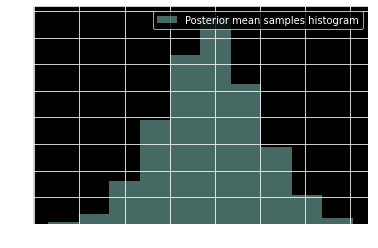

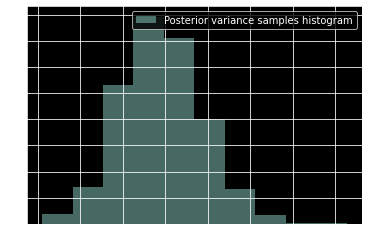

In [10]:
# univariate gaussian
class uGaussianEmission(uEmission):
    def __init__(self, n_gibbs:int = 1000, f_burn:float = 0.1, min_points_update = 5):
        
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.min_points_update = min_points_update
        # variables to be computed
        self.var = None
        self.mean = None        
        self.S0aux = None
        self.invV0, self.invV0m0 = None, None
        self.prev_mn, self.prev_Vn = None, None
        self.prev_vn, self.prev_Sn = None, None 
    
    def get_pdf_limits(self, k = 5):
        return self.mean - 5*np.sqrt(self.var), self.mean + 5*np.sqrt(self.var)
    
    def pdf(self, x):
        return np.exp(-0.5*np.power(x-self.mean,2)/self.var)/np.sqrt(2*np.pi*self.var)
        
    def view(self, plot_hist = False):
        print('** Univariate Gaussian Emission **')
        print('Mean')
        print(self.mean)
        print('Variance')
        print(self.var)
        print()
        if plot_hist:
            if self.gibbs_mean is not None:
                plt.hist(
                        self.gibbs_mean,
                        density=True,
                        alpha=0.5,
                        label='Posterior mean samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()
            if self.gibbs_var is not None:
                plt.hist(
                        self.gibbs_var,
                        density=True,
                        alpha=0.5,
                        label='Posterior variance samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()

    def gibbs_initialize(self, y, **kwargs):
        assert y.ndim == 1, "y must be a vector"
        # this will be updated later
        self.mean = 0         
        # Covariance samples
        self.gibbs_var = np.zeros(self.n_gibbs_sim) 
        # Mean samples
        self.gibbs_mean = np.zeros(self.n_gibbs_sim)          
        # compute data variance
        self.var = np.var(y)
        # Prior distribution parameters
        self.m0 = 0 # np.mean(y) # mean: prior location (just put it at zero...)
        self.v0 = self.var # mean: prior covariance        
        self.a0 = 2 # infinite variance...
        self.b0 = self.var        
        # initialize
        self.gibbs_mean[0] = self.m0
        self.gibbs_var[0] = self.var
        # store parameters
        self.prev_mn = self.m0
        self.prev_vn = self.v0
        self.prev_an = self.a0
        self.prev_bn = self.b0

    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        '''
        y: current set of observations
        to be called while in sampler
        '''
        assert y.ndim == 1, "y must be a vector"
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        # no observations in y
        if y.size < self.min_points_update:
            self.gibbs_mean[iteration] = np.random.normal(self.prev_mn, self.prev_vn)
            self.gibbs_var[iteration] = 1 / np.random.gamma(self.prev_an, 1 / self.prev_bn)
        else:
            n = y.size
            y_sum = np.sum(y)            
            # Sample from mean
            mn = (self.m0*self.gibbs_var[iteration-1] + self.v0*y_sum)
            mn /= (n*self.v0 + self.gibbs_var[iteration-1])            
            vn = self.gibbs_var[iteration-1] * self.v0 / (n*self.v0 + self.gibbs_var[iteration-1])
            self.prev_mn = mn
            self.prev_vn = vn
            self.gibbs_mean[iteration] = np.random.normal(mn, vn)
            # Sample from variance
            an = self.a0 + n/2
            bn = self.b0 + 0.5*np.sum(np.power(y-y_sum/n,2))
            self.prev_an = an
            self.prev_bn = bn
            self.gibbs_var[iteration] = 1 / np.random.gamma(an, 1 / bn)	

    def gibbs_burn_and_mean(self):
        self.gibbs_mean = self.gibbs_mean[-self.n_gibbs:]
        self.gibbs_var = self.gibbs_var[-self.n_gibbs:]		
        self.mean = np.mean(self.gibbs_mean)
        self.var = np.mean(self.gibbs_var)	
        self.w_norm = np.abs(self.mean / self.var) # betting weight
    
    def gibbs_prob(self, y:np.ndarray, iteration:int, **kwargs):
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        assert y.ndim == 1, "y must be a vector"
        p = np.exp(-0.5*np.power(y-self.gibbs_mean[iteration-1],2)/self.gibbs_var[iteration-1])
        p /= np.sqrt(2*np.pi*self.gibbs_var[iteration-1])
        return p
    
    def estimate(self, y:np.ndarray, **kwargs):
        # cycle to test individually the inference!
        self.gibbs_initialize(y)
        for i in range(1, self.n_gibbs_sim):
            self.gibbs_posterior_sample(y, i)
        self.gibbs_burn_and_mean()		
    
    def prob(self, y:np.ndarray,  **kwargs):
        # use vectorized function
        assert y.ndim == 1, "y must be a vector"
        return np.exp(-0.5 * np.power(y - self.mean, 2) / self.var) / np.sqrt(2*np.pi*self.var)
    
    def posterior_predictive(self, **kwargs):
        return self.mean, self.var
    
    def predict_pi(self, **kwargs):
        return 1
    
# run bayesian inference
y = np.random.normal(-1, np.sqrt(0.5), 1000)
g = uGaussianEmission()
g.estimate(y)
g.view(True)

dict_keys(['XP', 'EO', 'CF', 'GX', 'Z ', 'ST', 'IB', 'ES', 'NQ', 'PT', 'TP'])


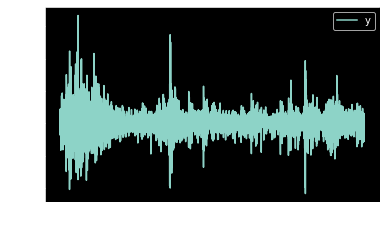

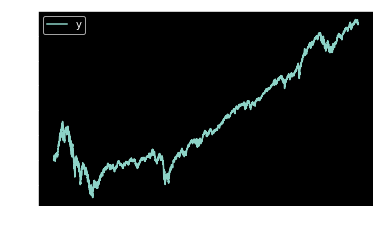

In [11]:
# test on STM with real data
import stm
import pickle
import pandas as pd
data = {}
filepath = 'indexes_data.pkl'
#filepath = 'fi_data.pkl'
#filepath = 'comm_data.pkl'

# load from pickle
with open(filepath, 'rb') as inp:
    tmp = pickle.load(inp)
    data.update(tmp) 
print(data.keys())
data = data['NQ']
data.columns = data.columns.droplevel(1)
data = data[[data.columns[0]]].dropna().pct_change().dropna()
data.columns = ['y']
data.index = pd.to_datetime(data.index)
data.plot()
plt.show()
np.cumsum(data, axis = 0).plot()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:06<00:00, 62.29s/it]


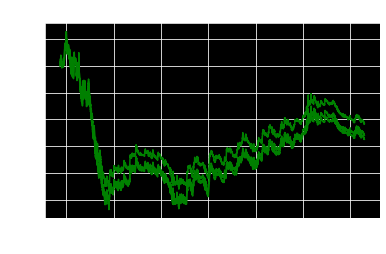

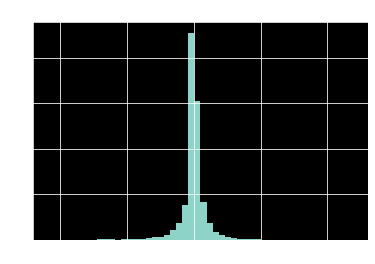

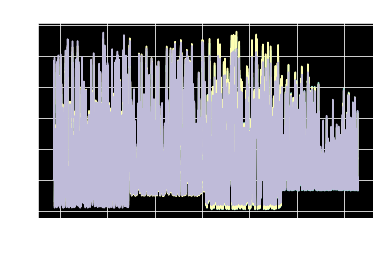

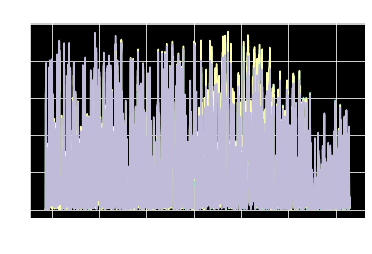

** REJECT STRATEGY **


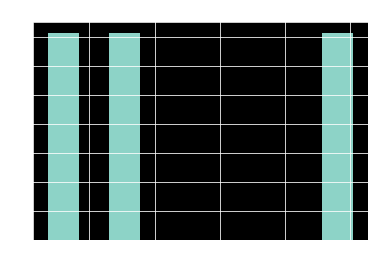

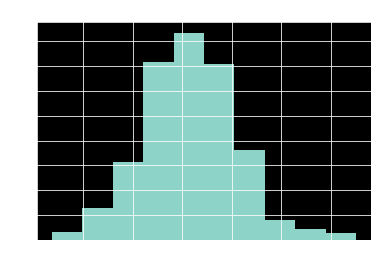


** PERFORMANCE SUMMARY **

Return:  -0.004790938979333175
Standard deviation:  0.03123262136603873
Sharpe:  -0.1533953529927743



In [12]:
dataset = stm.Dataset()
dataset.add('dataset', data)
model_pipe = stm.ModelPipe()

emissions = [uGaussianEmission(), uGaussianEmission()]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 2000,
            pred_l = 100,
            roll_var = True,
            )

model_pipe.add('dataset', model = uhmm)
paths = stm.cvbt(
        dataset = dataset, 
        model_pipe = model_pipe,
        n_paths = 3
     )

paths.post_process()

In [8]:
dataset = stm.Dataset()
dataset.add('dataset', data)
model_pipe = stm.ModelPipe()

emissions = [uGaussianEmission(), uGaussianEmission()]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 2000,
            pred_l = 100
            )

model_pipe.add('dataset', model = uhmm)
paths = stm.cvbt(
        dataset = dataset, 
        model_pipe = model_pipe,
        n_paths = 3
     )

paths.post_process()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]


NameError: name 'idx' is not defined